# Generative Adversarial Network (GAN) - Lab
#### Author: Kamil Barszczak

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import glob
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchsummary

import torchvision.utils as vutils

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#### Notebook parameters

In [2]:
dataset_path = 'E:/Data/CUB_200_2011'
train_test_split = 0.9
width, height = 64, 64
latent_dim = 64
epochs = 100
batch = 128

#### Set up device

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

#### Load and process data

In [4]:
bboxes = pd.read_csv(os.path.join(dataset_path, 'bounding_boxes.txt'), sep = " ", names=["id", "x", "y", "width", "height"]).astype(int)
annotations = pd.read_csv(os.path.join(dataset_path, 'images.txt'), sep = " ", names=["id", "path"])

processed = []
for index, row in tqdm(annotations.iterrows()):
    image_id = row.id
    image_path = row.path
    bbox  = bboxes[bboxes.id == image_id].iloc[0]
    
    img = cv2.imread(os.path.join(dataset_path, "images", image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[bbox.y:bbox.y + bbox.height, bbox.x:bbox.x + bbox.width, :]
    img = cv2.resize(img, (width, height))
    img = np.transpose((img.astype('float32') / 127.5 - 1), (2, 0, 1))
    
    processed.append(img)

11788it [00:44, 267.29it/s]


In [5]:
processed = np.array(processed)
np.random.shuffle(processed)
split = int(len(processed) * train_test_split)

train_dataloader = data.DataLoader(
    data.TensorDataset(torch.Tensor(processed[:split])),
    batch_size=batch,
    shuffle=True,
    drop_last=True
)

test_dataloader = data.DataLoader(
    data.TensorDataset(torch.Tensor(processed[split:])),
    batch_size=batch,
    drop_last=True
)

print("Train dataloader size:", len(train_dataloader))
print("Test dataloader size:", len(test_dataloader))

Train dataloader size: 82
Test dataloader size: 9


#### Create custom layers

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim, o_activation=nn.Tanh(), o_strides=1, o_kernel_size=3,
                dense_info = {
                    "neurons": [(256, 4, 4)],
                    "activations": [nn.ReLU()],
                    "use_norms": [False],
                    "dropouts": [0.0]
                },
                conv_info = {
                    "filters": [512, 256, 128, 64], 
                    "sizes": [4, 4, 4, 4], 
                    "strides": [2, 2, 2, 2], 
                    "activations": [nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2)], 
                    "use_norms": [True, True, True, True], 
                    "dropouts": [0.0, 0.0, 0.0, 0.0]
                }):
        super(Generator, self).__init__()
        
        last_output_size = latent_dim  # holds the size of the lately created layer
        modules = []  # array for the net modules
        
        # create proper dense layers
        for dn, da, dun, dd in zip(dense_info['neurons'], dense_info['activations'], dense_info['use_norms'], dense_info['dropouts']):
            current_size = dn[0] * dn[1] * dn[2]
            modules.append(nn.Linear(last_output_size, current_size))
            if dun:
                modules.append(nn.BatchNorm1d(current_size))
            if da is not None:
                modules.append(da)
            if dd > 0:
                modules.append(nn.Dropout(dd))
                
            last_output_size = current_size
            
        # reshape dense layers to 2d shape
        modules.append(nn.Unflatten(1, dense_info['neurons'][-1]))
        last_output_size = dense_info['neurons'][-1][0]
            
        # create proper conv transpose layers
        for cf, csiz, cstr, ca, cun, cd in zip(conv_info['filters'], conv_info['sizes'], conv_info['strides'], conv_info['activations'], conv_info['use_norms'], conv_info['dropouts']):
            modules.append(nn.ConvTranspose2d(last_output_size, cf, csiz, cstr, 1, bias=False))
            if cun:
                modules.append(nn.BatchNorm2d(cf))
            if ca is not None:
                modules.append(ca)
            if cd > 0:
                modules.append(nn.Dropout(dd))
            
            last_output_size = cf
            
        # add the output layers
        modules.append(nn.ConvTranspose2d(last_output_size, 3, o_kernel_size, o_strides, 1, bias=False))
        modules.append(o_activation)
        
        # create sequential model out of generated modules
        self.main = nn.Sequential(*modules)

    def forward(self, input):
        return self.main(input)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, height, width), o_activation=nn.Sigmoid(), flatten_shape=4096,
                dense_info = {
                    "neurons": [32],
                    "activations": [nn.ReLU()],
                    "use_norms": [False],
                    "dropouts": [0.0]
                },
                conv_info = {
                    "filters": [256, 128, 64], 
                    "sizes": [4, 4, 4], 
                    "strides": [2, 2, 2], 
                    "activations": [nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2)], 
                    "use_norms": [True, True, True], 
                    "dropouts": [0.0, 0.0, 0.0]
                }):
        super(Discriminator, self).__init__()
        
        last_output_size = input_shape[0]  # holds the size of the lately created layer
        modules = []  # array for the net modules
        
        # create proper conv layers
        for cf, csiz, cstr, ca, cun, cd in zip(conv_info['filters'], conv_info['sizes'], conv_info['strides'], conv_info['activations'], conv_info['use_norms'], conv_info['dropouts']):
            modules.append(nn.Conv2d(last_output_size, cf, csiz, cstr, 1, bias=False))
            if cun:
                modules.append(nn.BatchNorm2d(cf))
            if ca is not None:
                modules.append(ca)
            if cd > 0:
                modules.append(nn.Dropout(dd))
            
            last_output_size = cf
            
        # reshape dense layers to 2d shape
        modules.append(nn.Flatten(1, 3))
        last_output_size = flatten_shape
        
        # create proper dense layers
        for dn, da, dun, dd in zip(dense_info['neurons'], dense_info['activations'], dense_info['use_norms'], dense_info['dropouts']):
            modules.append(nn.Linear(last_output_size, dn))
            if dun:
                modules.append(nn.BatchNorm1d(current_size))
            if da is not None:
                modules.append(da)
            if dd > 0:
                modules.append(nn.Dropout(dd))
                
            last_output_size = dn
            
        # add the output layers
        modules.append(nn.Linear(last_output_size, 1))
        modules.append(o_activation)
        
        # create sequential model out of generated modules
        self.main = nn.Sequential(*modules)

    def forward(self, input):
        return self.main(input)

In [18]:
gan_generator = Generator().to(device)
gan_generator.apply(weights_init)
torchsummary.summary(gan_generator, (latent_dim, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         266,240
              ReLU-2                 [-1, 4096]               0
         Unflatten-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        LeakyReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [19]:
gan_discriminator = Discriminator().to(device)
gan_discriminator.apply(weights_init)
torchsummary.summary(gan_discriminator, (3, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]          12,288
       BatchNorm2d-2          [-1, 256, 32, 32]             512
         LeakyReLU-3          [-1, 256, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         524,288
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]         131,072
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                   [-1, 32]         131,104
             ReLU-12                   [-1, 32]               0
           Linear-13                    [-1, 1]              33
          Sigmoid-14                   

#### Train the net

Examples generated for random noise:


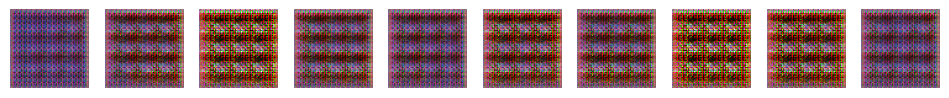

[  1/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0476	loss_g: 7.1461	real_avg: 0.9782	fake_avg: 0.0185 / 0.0010
[  2/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0214	loss_g: 7.5603	real_avg: 0.9876	fake_avg: 0.0082 / 0.0010
[  3/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0279	loss_g: 9.7049	real_avg: 0.9761	fake_avg: 0.0011 / 0.0001
[  4/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0154	loss_g: 7.1380	real_avg: 0.9953	fake_avg: 0.0102 / 0.00161
[  5/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0429	loss_g: 6.8641	real_avg: 0.9844	fake_avg: 0.0198 / 0.0018
Generator saved to: './models/gen_gloss=7.778257846832275_dloss=0.03071659430861473_time=1685386285.pth'
Discriminator saved to: './models/dis_gloss=7.778257846832275_dloss=0.03071659430861473_time=1685386285.pth'
Examples generated for random noise:


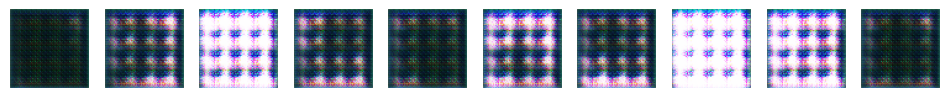

[  6/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0249	loss_g: 7.9463	real_avg: 0.9867	fake_avg: 0.0094 / 0.0005
[  7/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0200	loss_g: 7.2783	real_avg: 0.9850	fake_avg: 0.0038 / 0.0008
[  8/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0083	loss_g: 7.5297	real_avg: 0.9971	fake_avg: 0.0053 / 0.0009
[  9/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0339	loss_g: 6.7512	real_avg: 0.9852	fake_avg: 0.0159 / 0.00211
[ 10/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0084	loss_g: 9.7104	real_avg: 0.9936	fake_avg: 0.0015 / 0.0002
Generator saved to: './models/gen_gloss=9.608467102050781_dloss=0.0030547871720045805_time=1685386436.pth'
Discriminator saved to: './models/dis_gloss=9.608467102050781_dloss=0.0030547871720045805_time=1685386436.pth'
Examples generated for random noise:


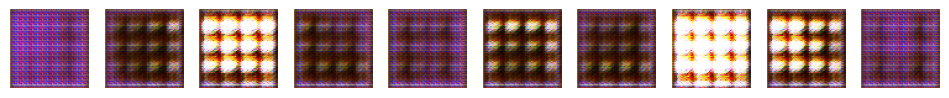

[ 11/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0383	loss_g: 6.8357	real_avg: 0.9828	fake_avg: 0.0163 / 0.0024
[ 12/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0124	loss_g: 6.8129	real_avg: 0.9951	fake_avg: 0.0071 / 0.0029
[ 13/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0055	loss_g: 8.6015	real_avg: 0.9964	fake_avg: 0.0015 / 0.0007
[ 14/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0051	loss_g: 7.8974	real_avg: 0.9971	fake_avg: 0.0022 / 0.0007
[ 15/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0337	loss_g: 9.1731	real_avg: 0.9848	fake_avg: 0.0093 / 0.0003
Generator saved to: './models/gen_gloss=9.012222290039062_dloss=0.02424871176481247_time=1685386587.pth'
Discriminator saved to: './models/dis_gloss=9.012222290039062_dloss=0.02424871176481247_time=1685386587.pth'
Examples generated for random noise:


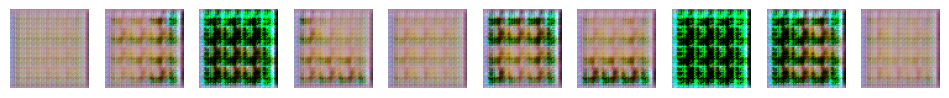

[ 16/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0035	loss_g: 11.9018	real_avg: 0.9969	fake_avg: 0.0002 / 0.0000
[ 17/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0473	loss_g: 9.4822	real_avg: 0.9819	fake_avg: 0.0197 / 0.00061
[ 18/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0423	loss_g: 8.1340	real_avg: 0.9777	fake_avg: 0.0134 / 0.00051
[ 19/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0083	loss_g: 10.6436	real_avg: 0.9925	fake_avg: 0.0003 / 0.0001
[ 20/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0182	loss_g: 10.5587	real_avg: 0.9882	fake_avg: 0.0012 / 0.0001
Generator saved to: './models/gen_gloss=10.111709594726562_dloss=0.010776150971651077_time=1685386739.pth'
Discriminator saved to: './models/dis_gloss=10.111709594726562_dloss=0.010776150971651077_time=1685386739.pth'
Examples generated for random noise:


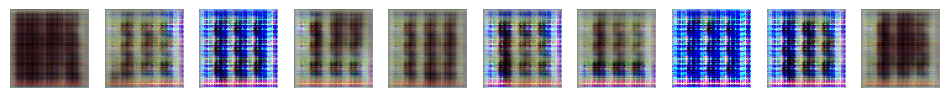

[ 21/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0348	loss_g: 8.4432	real_avg: 0.9806	fake_avg: 0.0095 / 0.00181
[ 22/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0280	loss_g: 7.7461	real_avg: 0.9993	fake_avg: 0.0242 / 0.00241
[ 23/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0128	loss_g: 7.0314	real_avg: 0.9968	fake_avg: 0.0092 / 0.00273
[ 24/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0084	loss_g: 11.8441	real_avg: 0.9952	fake_avg: 0.0030 / 0.0003
[ 25/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0069	loss_g: 9.0147	real_avg: 0.9970	fake_avg: 0.0034 / 0.00102
Generator saved to: './models/gen_gloss=8.93806266784668_dloss=0.014901903457939625_time=1685386891.pth'
Discriminator saved to: './models/dis_gloss=8.93806266784668_dloss=0.014901903457939625_time=1685386891.pth'
Examples generated for random noise:


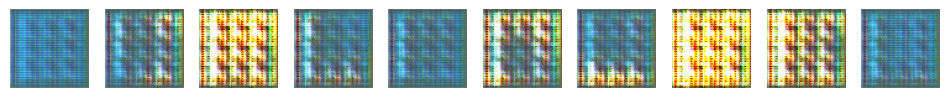

[ 26/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0136	loss_g: 7.7621	real_avg: 0.9967	fake_avg: 0.0097 / 0.00091
[ 27/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0297	loss_g: 6.9911	real_avg: 0.9857	fake_avg: 0.0125 / 0.00335
[ 28/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0071	loss_g: 10.5814	real_avg: 0.9986	fake_avg: 0.0054 / 0.0008
[ 29/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0474	loss_g: 11.1187	real_avg: 0.9782	fake_avg: 0.0005 / 0.0002
[ 30/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0055	loss_g: 8.4351	real_avg: 0.9989	fake_avg: 0.0043 / 0.00334
Generator saved to: './models/gen_gloss=8.103158950805664_dloss=0.027090083807706833_time=1685387042.pth'
Discriminator saved to: './models/dis_gloss=8.103158950805664_dloss=0.027090083807706833_time=1685387042.pth'
Examples generated for random noise:


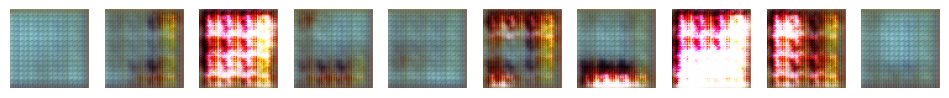

[ 31/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0018	loss_g: 10.5088	real_avg: 0.9994	fake_avg: 0.0011 / 0.0001
[ 32/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0047	loss_g: 9.6559	real_avg: 0.9972	fake_avg: 0.0018 / 0.00093
[ 33/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0037	loss_g: 10.4999	real_avg: 0.9996	fake_avg: 0.0030 / 0.0012
[ 34/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0207	loss_g: 10.6485	real_avg: 0.9854	fake_avg: 0.0004 / 0.0001
[ 35/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0598	loss_g: 8.8438	real_avg: 0.9996	fake_avg: 0.0477 / 0.00082
Generator saved to: './models/gen_gloss=9.617756843566895_dloss=0.046068813651800156_time=1685387193.pth'
Discriminator saved to: './models/dis_gloss=9.617756843566895_dloss=0.046068813651800156_time=1685387193.pth'
Examples generated for random noise:


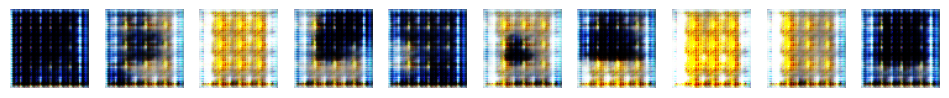

[ 36/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0587	loss_g: 10.4963	real_avg: 0.9998	fake_avg: 0.0412 / 0.0040
[ 37/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0320	loss_g: 11.3719	real_avg: 0.9873	fake_avg: 0.0008 / 0.0001
[ 38/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0011	loss_g: 11.5930	real_avg: 0.9990	fake_avg: 0.0001 / 0.0001
[ 39/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0637	loss_g: 9.3827	real_avg: 0.9603	fake_avg: 0.0011 / 0.00052
[ 40/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0744	loss_g: 7.1075	real_avg: 0.9676	fake_avg: 0.0077 / 0.00563
Generator saved to: './models/gen_gloss=7.389674663543701_dloss=0.038158614188432693_time=1685387344.pth'
Discriminator saved to: './models/dis_gloss=7.389674663543701_dloss=0.038158614188432693_time=1685387344.pth'
Examples generated for random noise:


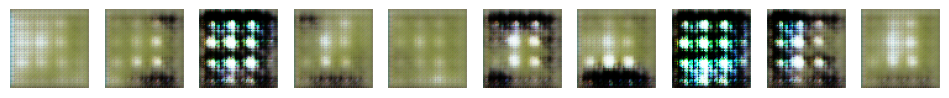

[ 41/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0123	loss_g: 7.5133	real_avg: 0.9987	fake_avg: 0.0107 / 0.00402
[ 42/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0170	loss_g: 8.0213	real_avg: 0.9895	fake_avg: 0.0034 / 0.00082
[ 43/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0156	loss_g: 7.2506	real_avg: 0.9945	fake_avg: 0.0095 / 0.00211
[ 44/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0058	loss_g: 8.2222	real_avg: 0.9999	fake_avg: 0.0056 / 0.00081
[ 45/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0550	loss_g: 7.4024	real_avg: 0.9847	fake_avg: 0.0170 / 0.0054
Generator saved to: './models/gen_gloss=8.300580024719238_dloss=0.014043182134628296_time=1685387495.pth'
Discriminator saved to: './models/dis_gloss=8.300580024719238_dloss=0.014043182134628296_time=1685387495.pth'
Examples generated for random noise:


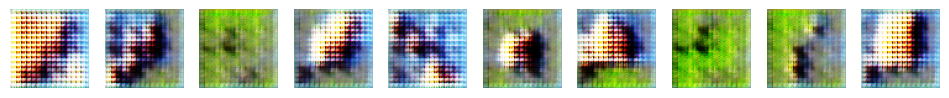

[ 46/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0106	loss_g: 10.5318	real_avg: 0.9924	fake_avg: 0.0021 / 0.0006
[ 47/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0133	loss_g: 7.7368	real_avg: 1.0000	fake_avg: 0.0122 / 0.00509
[ 48/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0150	loss_g: 8.8035	real_avg: 0.9906	fake_avg: 0.0034 / 0.00195
[ 49/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0021	loss_g: 9.2900	real_avg: 0.9987	fake_avg: 0.0008 / 0.00021
[ 50/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0572	loss_g: 14.7986	real_avg: 0.9823	fake_avg: 0.0000 / 0.0000
Generator saved to: './models/gen_gloss=14.518278121948242_dloss=0.02653391659259796_time=1685387646.pth'
Discriminator saved to: './models/dis_gloss=14.518278121948242_dloss=0.02653391659259796_time=1685387646.pth'
Examples generated for random noise:


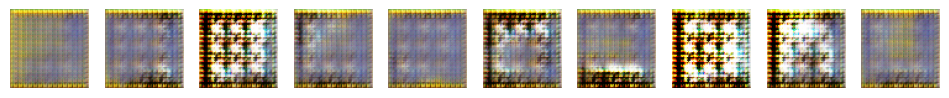

[ 51/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0169	loss_g: 8.5930	real_avg: 0.9922	fake_avg: 0.0032 / 0.00338
[ 52/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0385	loss_g: 10.1178	real_avg: 0.9835	fake_avg: 0.0007 / 0.0006
[ 53/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0001	loss_g: 14.4672	real_avg: 0.9999	fake_avg: 0.0000 / 0.0000
[ 54/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0438	loss_g: 7.3782	real_avg: 0.9979	fake_avg: 0.0379 / 0.00221
[ 55/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0011	loss_g: 8.9285	real_avg: 0.9994	fake_avg: 0.0005 / 0.00031
Generator saved to: './models/gen_gloss=8.72391414642334_dloss=0.0019755458924919367_time=1685387797.pth'
Discriminator saved to: './models/dis_gloss=8.72391414642334_dloss=0.0019755458924919367_time=1685387797.pth'
Examples generated for random noise:


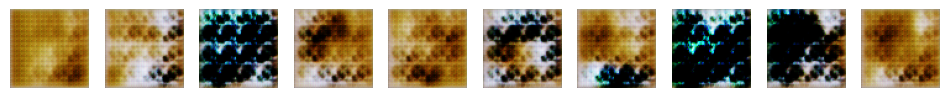

[ 56/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0086	loss_g: 7.8525	real_avg: 0.9938	fake_avg: 0.0014 / 0.00151
[ 57/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0063	loss_g: 8.8959	real_avg: 0.9982	fake_avg: 0.0043 / 0.00162
[ 58/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0036	loss_g: 10.6201	real_avg: 0.9972	fake_avg: 0.0005 / 0.0002
[ 59/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0075	loss_g: 10.5360	real_avg: 0.9999	fake_avg: 0.0068 / 0.0002
[ 60/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0135	loss_g: 11.2438	real_avg: 0.9940	fake_avg: 0.0036 / 0.0001
Generator saved to: './models/gen_gloss=10.97665786743164_dloss=0.04069649055600166_time=1685387948.pth'
Discriminator saved to: './models/dis_gloss=10.97665786743164_dloss=0.04069649055600166_time=1685387948.pth'
Examples generated for random noise:


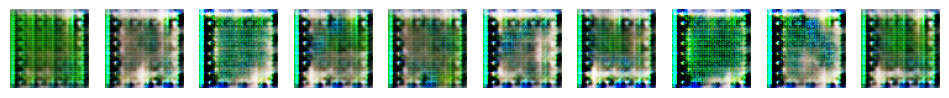

[ 61/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.2630	loss_g: 11.0853	real_avg: 0.9881	fake_avg: 0.1127 / 0.0008
[ 62/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0016	loss_g: 13.8204	real_avg: 0.9986	fake_avg: 0.0002 / 0.0000
[ 63/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0091	loss_g: 9.7636	real_avg: 0.9944	fake_avg: 0.0028 / 0.00024
[ 64/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0060	loss_g: 10.8214	real_avg: 0.9991	fake_avg: 0.0048 / 0.0019
[ 65/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0312	loss_g: 9.8664	real_avg: 0.9832	fake_avg: 0.0029 / 0.00054
Generator saved to: './models/gen_gloss=9.715500831604004_dloss=0.016090936958789825_time=1685388099.pth'
Discriminator saved to: './models/dis_gloss=9.715500831604004_dloss=0.016090936958789825_time=1685388099.pth'
Examples generated for random noise:


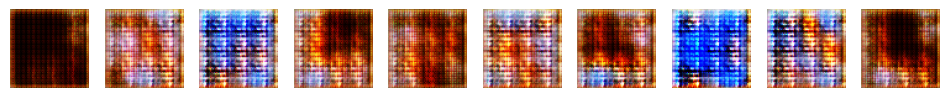

[ 66/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0243	loss_g: 8.6166	real_avg: 0.9976	fake_avg: 0.0193 / 0.00312
[ 67/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0219	loss_g: 8.0407	real_avg: 0.9898	fake_avg: 0.0095 / 0.00493
[ 68/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0134	loss_g: 7.1283	real_avg: 0.9995	fake_avg: 0.0122 / 0.00862
[ 69/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0166	loss_g: 7.8802	real_avg: 0.9993	fake_avg: 0.0145 / 0.00623
[ 70/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.1035	loss_g: 10.7367	real_avg: 0.9632	fake_avg: 0.0051 / 0.0005
Generator saved to: './models/gen_gloss=11.249326705932617_dloss=0.02698911353945732_time=1685388250.pth'
Discriminator saved to: './models/dis_gloss=11.249326705932617_dloss=0.02698911353945732_time=1685388250.pth'
Examples generated for random noise:


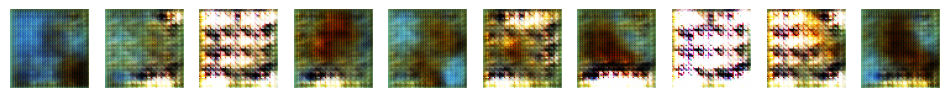

[ 71/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0041	loss_g: 7.7944	real_avg: 0.9991	fake_avg: 0.0031 / 0.00221
[ 72/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.1639	loss_g: 9.0492	real_avg: 0.9902	fake_avg: 0.0815 / 0.00533
[ 73/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.1447	loss_g: 10.9056	real_avg: 0.9327	fake_avg: 0.0014 / 0.0001
[ 74/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0743	loss_g: 10.8609	real_avg: 0.9559	fake_avg: 0.0002 / 0.0001
[ 75/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0411	loss_g: 7.0379	real_avg: 0.9902	fake_avg: 0.0249 / 0.00733
Generator saved to: './models/gen_gloss=7.145824909210205_dloss=0.0251455120742321_time=1685388401.pth'
Discriminator saved to: './models/dis_gloss=7.145824909210205_dloss=0.0251455120742321_time=1685388401.pth'
Examples generated for random noise:


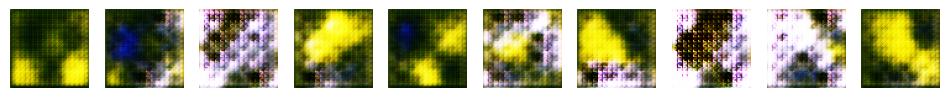

[ 76/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0054	loss_g: 10.2084	real_avg: 0.9966	fake_avg: 0.0017 / 0.0004
[ 77/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0229	loss_g: 7.5278	real_avg: 0.9870	fake_avg: 0.0079 / 0.00293
[ 78/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0217	loss_g: 7.4638	real_avg: 0.9905	fake_avg: 0.0103 / 0.01184
[ 79/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0302	loss_g: 8.3027	real_avg: 0.9863	fake_avg: 0.0051 / 0.00101
[ 80/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0298	loss_g: 6.5252	real_avg: 0.9821	fake_avg: 0.0049 / 0.00582
Generator saved to: './models/gen_gloss=6.506706714630127_dloss=0.012159447185695171_time=1685388552.pth'
Discriminator saved to: './models/dis_gloss=6.506706714630127_dloss=0.012159447185695171_time=1685388552.pth'
Examples generated for random noise:


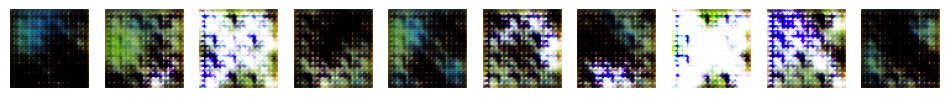

[ 81/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0291	loss_g: 10.5047	real_avg: 0.9784	fake_avg: 0.0011 / 0.0001
[ 82/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0659	loss_g: 7.6070	real_avg: 0.9756	fake_avg: 0.0145 / 0.00191
[ 83/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0021	loss_g: 10.8622	real_avg: 0.9994	fake_avg: 0.0014 / 0.0001
[ 84/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0294	loss_g: 7.8158	real_avg: 0.9994	fake_avg: 0.0248 / 0.00424
[ 85/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0023	loss_g: 8.7446	real_avg: 0.9991	fake_avg: 0.0014 / 0.00082
Generator saved to: './models/gen_gloss=8.59973430633545_dloss=0.002016563666984439_time=1685388703.pth'
Discriminator saved to: './models/dis_gloss=8.59973430633545_dloss=0.002016563666984439_time=1685388703.pth'
Examples generated for random noise:


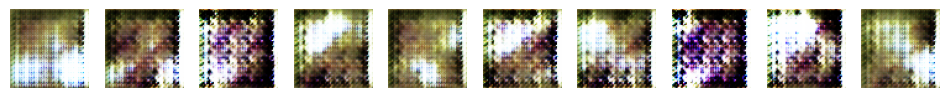

[ 86/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0458	loss_g: 7.3429	real_avg: 0.9803	fake_avg: 0.0127 / 0.00814
[ 87/100][ 82/ 82]	(eta: 00:00:00)	loss_d: 0.0781	loss_g: 8.6675	real_avg: 0.9871	fake_avg: 0.0174 / 0.00754
[ 88/100][ 72/ 82]	(eta: 00:00:03)	loss_d: 0.0147	loss_g: 11.2740	real_avg: 0.9869	fake_avg: 0.0002 / 0.0001

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [25]:
fixed_noise = torch.randn(batch, latent_dim, device=device)
loss = nn.BCELoss()

save_freq = 25 # epochs
gen_freq = 5 # epochs
view_limit = 10

optimizer_d = optim.Adam(gan_discriminator.parameters(), lr=1e-4)
optimizer_g = optim.Adam(gan_generator.parameters(), lr=1e-4)

losses_d = []
losses_g = []

for epoch in range(epochs):
    for i, data in enumerate(train_dataloader, 0):
        label = torch.full((batch, ), 1.0, dtype=torch.float, device=device)  # create tensor of real labels (1.0)

        # ----- Train the discriminator
        start = time.time()

        # pass for real data
        gan_discriminator.zero_grad()  # clear grads for discriminator
        real_data = data[0].to(device)  # load real data to selected device
        output = gan_discriminator(real_data).view(-1)  # forward pass
        if torch.any(torch.isnan(output)):
            continue
        loss_dis_real = loss(output, label)  # calculate the loss
        loss_dis_real.backward()  # calculate the gradient
        real_mean = output.mean().item()  # calculate the average loss for the given batch

        # pass for fake data
        noise = torch.randn(batch, latent_dim, device=device)  # create random noice for generator
        label.fill_(0.0)  # fill the label with fake label value (0.0)
        fake_data = gan_generator(noise)  # forward pass for generator (generate images)
        output = gan_discriminator(fake_data.detach()).view(-1)  # forward pass
        if torch.any(torch.isnan(output)):
            continue
        loss_dis_fake = loss(output, label)  # calculate the loss
        loss_dis_fake.backward()  # calculate the gradient
        fake_1_mean = output.mean().item()  # calculate the average loss for generated batch

        # apply gradient
        loss_dis = loss_dis_real + loss_dis_fake  # calculate discriminator loss
        optimizer_d.step()  # apply the gradient for discriminator

        # ----- Train the generator
        gan_generator.zero_grad()  # clear grads for generator
        label.fill_(1.0)  # fake labels are real for generator cost
        output = gan_discriminator(fake_data).view(-1)  # forward pass for fake data with updated discriminator
        if torch.any(torch.isnan(output)):
            continue
        loss_gen = loss(output, label)  # calculate generator loss
        loss_gen.backward()  # calculate gradient
        fake_2_mean = output.mean().item()  # calculate the average batch loss for the generator
        optimizer_g.step()  # apply the gradient for generator

        end = time.time()
        
        # save learning state
        if epoch % save_freq == 0 and epoch > 0 and i == 0:
            gen_filename = f'./models/gen_gloss={loss_gen.item()}_dloss={loss_dis.item()}_time={int(time.time())}.pth'
            dis_filename = f'./models/dis_gloss={loss_gen.item()}_dloss={loss_dis.item()}_time={int(time.time())}.pth'
            torch.save(gan_generator.state_dict(), gen_filename)
            torch.save(gan_discriminator.state_dict(), dis_filename)
            print(f"Generator saved to: '{gen_filename}'")
            print(f"Discriminator saved to: '{dis_filename}'")
            
        # log generation status
        if epoch % gen_freq == 0 and i == 0: 
            with torch.no_grad():
                fake = gan_generator(fixed_noise).detach().cpu()
                
            print("Examples generated for random noise:")
            fake = fake[:view_limit]
            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(fake):
                fig.add_subplot(1, view_limit, i+1)
                plt.imshow((np.transpose(image.numpy(), (1, 2, 0)) + 1) * 0.5)
                plt.axis('off')
            plt.show()
            
        # output training stats
        time_left = (end-start) * (len(train_dataloader) - (i+1))
        print('\r[%3d/%3d][%3d/%3d]\t(eta: %s)\tloss_d: %.4f\tloss_g: %.4f\treal_avg: %.4f\tfake_avg: %.4f / %.4f'
              % ((epoch+1), epochs, (i+1), len(train_dataloader), time.strftime('%H:%M:%S', time.gmtime(time_left)),
                 loss_dis.item(), loss_gen.item(), real_mean, fake_1_mean, fake_2_mean), end='')
        
        if i == len(train_dataloader)-1:
            print()
            
        # save losses
        losses_g.append(loss_gen.item())
        losses_d.append(loss_dis.item())

#### Save trained generator and discriminator

In [ ]:
torch.save(gan_generator.state_dict(), './gen.pth')
torch.save(gan_discriminator.state_dict(), './dis.pth')